
In this project, we would focus on combining RFM (Recency Frequency Monetary) Analysis with Clustering analysis to to identify different market segments .  


# Business Problem 
-------

Customer Analytics is important to run a successful business. Sales and marketing resources are finite and expensive, therefore it is important to answer these questions when developing a marketing strategy.

* Who are our most/least valuable customers?
* How can we acquire new customers that resemble our most valuable?

The Recency-Frequency-Monetary value segmentation has been around for a while now and provides a pretty simple but effective way to segment customers.The project on [RFM analysis](https://master-of-business-analytics.github.io/Website/RFM_Analysis.html) provided a basic model that allows the business to segment its customers based on three criteria based on an existing customer’s transaction history; recency of Customer's Last purchase, frequency of purchases and total amount spent, which is referred to as monetary. 
However, A RFM model can be used in conjunction with certain predictive models to gain even further insight into customer behavior. In this project, we analyze the K means cluster and  see how it enhance results from RFM analysis.

Here is a high level flow of the analysis.

* Calculate R, F and M parameters
* Apply k-means clustering algorithm on these parameters to group similar customers.

K-means is a popular approach for classification because of simplicity of implementation and been widely used in market segmentation. The number of clusters can be determined by using the elbow method


## Data Set

There are  eight variables in the data set:

1. InvoiceNo: Invoice number,  A 6-digit integral number uniquely assigned to each transaction.
2. StockCode: Product code, a 5-digit integral number uniquely assigned to each distinct product.
3. Description: Product name
4. Quantity: The quantities of each product (item) per transaction.
5. InvoiceDate: Invoice Date and time. Numeric, the day and time when each transaction was generated.
6. UnitPrice: Unit price. Numeric, Product price per unit in sterling.
7. CustomerID: Customer number, a 5-digit integral number uniquely assigned to each customer.
8. Country 

In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import timedelta
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.cluster import KMeans
#ignore warnings
warnings.filterwarnings('ignore')

pd.set_option("display.max_columns",None);
pd.set_option("display.max_rows",None);

#load data
url = 'https://raw.githubusercontent.com/Master-of-Business-Analytics/Project_06_RFM_Analysis/master/data_1.csv'
df = pd.read_csv(url, error_bad_lines=False,encoding= 'unicode_escape')




In [20]:
#summary of dataset
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,540558,21258,?,-29,2011-01-10 10:04:00,0.00,NaN,United Kingdom
1,540560,21589,NaN,-14,2011-01-10 10:08:00,0.00,NaN,United Kingdom
2,540561,22343,PARTY PIZZA DISH RED RETROSPOT,24,2011-01-10 10:32:00,0.21,13004.0,United Kingdom
3,540561,22344,PARTY PIZZA DISH PINK POLKADOT,24,2011-01-10 10:32:00,0.21,13004.0,United Kingdom
4,540561,47504H,ENGLISH ROSE SPIRIT LEVEL,24,2011-01-10 10:32:00,0.85,13004.0,United Kingdom


# Data cleaning 

The dataset seemed relatively clean at first glance, but it was riddled with errors. There were quite a number of these positive/negative offsetting entries throughout the dataset, plus other apparent errors such as customers with negative transactions. More information on data cleaning can be found on the [data cleaning project](https://master-of-business-analytics.github.io/Website/Data_Cleaning.html).

The first step in cleaning the dataset is to check if there are any missing values and where the missing values are located.

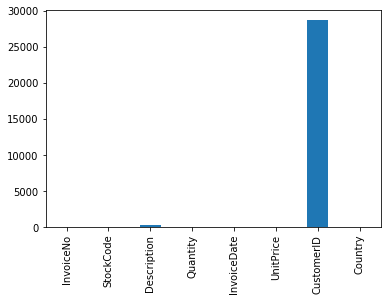

In [21]:

#Visualize the number of null values in the dataframe for each column
df.isnull().sum().plot(kind='bar')

The bar chart above shows that NaN values are located at the description and customer ID column. The purpose of this evaluating is current customer segmentation therefore transactions without customer ID do not provide any value and are dropped from the data frame below.  

In [22]:
#Eliminating rows with NA
df=df.dropna(subset=['CustomerID'])

#NA status across columns
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [23]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,60426.000000,60426.000000,60426.000000
mean,11.121868,3.134313,15500.429368
std,429.524058,6.663764,1597.854971
min,-74215.000000,0.000000,12346.000000
25%,2.000000,1.250000,14180.000000
50%,4.000000,1.950000,15408.000000
75%,12.000000,3.750000,16931.000000
max,74215.000000,856.480000,18283.000000


The summary table shows that very low negative values under the quantity values. Further analysis show that the minimum and maximum values have the same absolute values. This could be as a result of a mistake in data entry. There are two ways data input error is usually corrected; entering a value with the opposite sign to nullify the previous mistake or entering the difference between actual actual transaction and previous entry. 

The first instance corrected by:
1. Confirming that both transactions are for one customer and drop the rows if true. 
2. Repeating the previous step until the the minimum and maximum quantity values do not have the same absolute values.

In [24]:
#First of all we select relevant columns
df2 = df[['InvoiceDate',"CustomerID",'StockCode','UnitPrice','Quantity']]
#snapshoot of new dataframe
df2.head()

,InvoiceDate,CustomerID,StockCode,UnitPrice,Quantity
2,2011-01-10 10:32:00,13004.0,22343,0.21,24
3,2011-01-10 10:32:00,13004.0,22344,0.21,24
4,2011-01-10 10:32:00,13004.0,47504H,0.85,24
5,2011-01-10 10:32:00,13004.0,84509G,1.25,12
6,2011-01-10 10:32:00,13004.0,22720,4.95,3


In [25]:
#row data of maximum and minimum data
df2.loc[[df2['Quantity'].idxmax(),df['Quantity'].idxmin()]]

,InvoiceDate,CustomerID,StockCode,UnitPrice,Quantity
10537,2011-01-18 10:01:00,12346.0,23166,1.04,74215
10542,2011-01-18 10:17:00,12346.0,23166,1.04,-74215


In [26]:
#remove containing row minimum and maximum quantity as it is basically a duplicate
df2.drop(index=[df2['Quantity'].idxmax(), df2['Quantity'].idxmin()], inplace=True)

#chack minimum and maximum quantity 
df2.describe()

,CustomerID,UnitPrice,Quantity
count,60424.000000,60424.000000,60424.000000
mean,15500.533778,3.134383,11.122236
std,1597.778348,6.663863,46.762862
min,12747.000000,0.000000,-720.000000
25%,14180.000000,1.250000,2.000000
50%,15408.000000,1.950000,4.000000
75%,16931.000000,3.750000,12.000000
max,18283.000000,856.480000,3906.000000


<b> Note that the Minimum quantity and Maximum quantity do not have the same absolute values. However, if this was not the case, the above step is repeated</b>

The next step is to convert the date column to a date format and add the total sales column

In [29]:
# Convert InvoiceDate from object to datetime format
df2['InvoiceDate'] = pd.to_datetime(df2['InvoiceDate'])

#remove minutes and seconds from date
df2['InvoiceDate'] = df2.InvoiceDate.dt.date

                        
#creating a total sales column
df2["Totalsum"] = df2['Quantity'] * df2['UnitPrice']

df2.head(5)

,InvoiceDate,CustomerID,StockCode,UnitPrice,Quantity,Totalsum
2,2011-01-10,13004.0,22343,0.21,24,5.04
3,2011-01-10,13004.0,22344,0.21,24,5.04
4,2011-01-10,13004.0,47504H,0.85,24,20.40
5,2011-01-10,13004.0,84509G,1.25,12,15.00
6,2011-01-10,13004.0,22720,4.95,3,14.85


In [30]:
# information about the data set
print('{:,} rows; {:,} columns'
      .format(df2.shape[0], df2.shape[1]))
print('{:,} transactions don\'t have a customer id'
      .format(df2[df2.CustomerID.isnull()].shape[0]))
print('Transactions timeframe from {} to {}'.format(df2['InvoiceDate'].min(),
                                    df2['InvoiceDate'].max()))

60,424 rows; 6 columns
0 transactions don't have a customer id
Transactions timeframe from 2011-01-04 to 2011-03-30


# RFM model

The RFM model describes current customers historical purchase behavior using 3 feature:

* When did the customer make their last purchase?
* How often does the customer make a purchase?
*  How much money does the customer spend?

The general assumption with the RFM model is that Customers that purchase in shorter time intervals in
greater volumes at higher prices are more like to respond positively to future engagement and product offers.  
The customer records are grouped by recency of their purchase, the frequency by their quantity, and the monetary value of the purchases. 

In [32]:
# create a table that aggregates the transactions by customer id to 
# obtain recency score, frequency of purchase and monetary value


# set current date as most recent date plus one day
#df2['snapshot'] = df2['InvoiceDate'] + timedelta(days=1)  

#group customers by their most recent purchase
snapshot_date = df2['InvoiceDate'].max() + timedelta(days=1)  

#creat recency table by comparing most recent transaction to snapshot date by customer ID
rec_df = snapshot_date-df2.groupby("CustomerID").agg({"InvoiceDate":max}) 

#renaming column names
rec_df.rename(columns={"InvoiceDate": "Recency"}, inplace=True)#rename column
rec_df=rec_df["Recency"].apply(lambda x: x.days) #extracting number of days only

#creating frequency and monetary table by grouping number of purchases and total money spent by customer ID
fmTable = df2.groupby('CustomerID').agg({'CustomerID': lambda x: len(x),               # Frequency
                                        'Totalsum': lambda x: x.sum()})          # Monetary Value
#renaming column names
fmTable.rename(columns={
                         'CustomerID': 'Frequency', 
                         'Totalsum': 'Monetary'}, inplace=True)

#combining the fm table and the recency table

rfm_df = pd.concat([rec_df,fmTable],axis=1)
rfm_df.head()


,Recency,Frequency,Monetary
CustomerID,,,
12747.0,30,17.0,613.82
12748.0,6,337.0,1820.35
12820.0,73,11.0,170.46
12823.0,1,3.0,994.50
12826.0,63,40.0,542.10


# Cluster Analysis 
Clustering is the process of dividing the entire data into groups (also known as clusters) based on the patterns in the data. The k-means clustering technique is an algorithm that tries to minimize the distance of the points in a cluster with their centroid. There are two steps in cluster analysis:

1. Finding the optimal number of clusters: the number of cluster values where this decrease in inertia value becomes constant can be chosen as the right number of clusters for our data.

2. Fit to kmeans model
 
Looking at the rfm data table above,  there is a lot of variation in the magnitude of the data. Since K-Means is a distance-based algorithm, this difference of magnitude can create a problem, therefore all the variables are standardized to the same magnitude using the scaler function.

In [39]:


# --Calculate R and F groups--
rfm_df1= rfm_df.copy()

# Create labels for Recency and Frequency and MonetaryValue
r_labels = range(4, 0, -1) #[4,3,2,1] 
f_labels = range(1, 5)   #[1,2,3,4]
#m_labels = range(1, 5)

# Assign these labels to 4 equal percentile groups 
r_groups = pd.qcut(rfm_df1['Recency'], q=4, labels=r_labels)
# Assign these labels to1111 4 equal percentile groups 
f_groups = pd.qcut(rfm_df1['Frequency'], q=4, labels=f_labels)

# Assign these labels to three equal percentile groups 
#m_groups = pd.qcut(rfm_df1['Monetary'], q=4, labels=m_labels)



# Create new columns R_score, M_score and F_score  
#rfm_df1 = rfm_df1.assign(R_score = r_groups.values, F_score = f_groups.values, M_score = m_groups.values)
#rfm_df1 = rfm_df1.assign(R_score = r_groups.values, F_score = f_groups.values)
#rfm_df1 = rfm_df1[['R_score','F_score','M_score']]
#rfm_df1 = rfm_df1[['R_score','F_score']]
#rfm_df1.head()

In [33]:
# standardizing the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_scaled = scaler.fit_transform(rfm_df)


Text(0.5, 1.0, 'Elbow Curve')

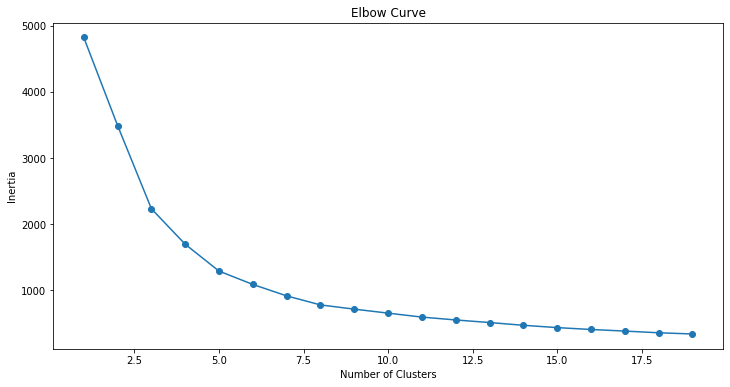

In [35]:
# fitting multiple k-means algorithms and storing the values in an empty list
SSE = []
for cluster in range(1,20):
    kmeans = KMeans(n_jobs = -1, n_clusters = cluster, init='k-means++')
    kmeans.fit(data_scaled)
    SSE.append(kmeans.inertia_)

# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(1,20), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Curve')

In [44]:
kmeans = KMeans(n_jobs = -1, n_clusters = 4, init='k-means++')
kmeans.fit(data_scaled)
pred = kmeans.predict(data_scaled)
rfm_df['cluster'] = pred
rfm_df.head()

,Recency,Frequency,Monetary,cluster
CustomerID,,,,
12747.0,30,17.0,613.82,1
12748.0,6,337.0,1820.35,2
12820.0,73,11.0,170.46,0
12823.0,1,3.0,994.50,1
12826.0,63,40.0,542.10,0


In [45]:
#Cluster number
rfm_df.cluster.value_counts()

1    934
0    568
2     96
3      9
Name: cluster, dtype: int64

<b>The cluster value where this decrease in inertia value becomes constant can be chosen as the right cluster value for our data. Looking at the above elbow curve, we can choose any number of clusters between 4 to 6. The number of clusters is set as 5 and fit the model.</b>

One must also look at the computation cost while deciding the number of clusters. If a higher number of clusters is selected, the computation cost would increase.

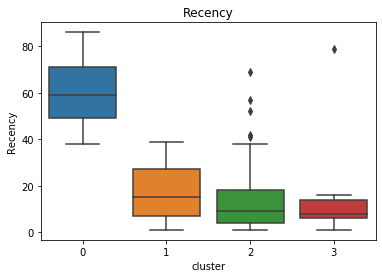

In [46]:
#Recency plot
sns.boxplot(rfm_df.cluster,rfm_df.Recency)
plt.title('Recency')
plt.show()

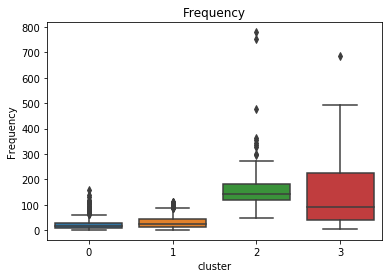

In [47]:
sns.boxplot(rfm_df.cluster,rfm_df.Frequency)
plt.title('Frequency')
plt.show()

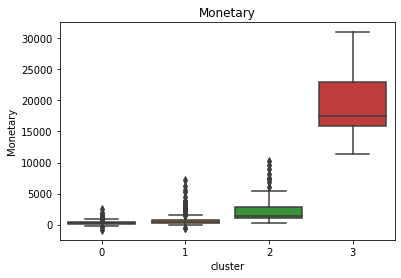

In [48]:
sns.boxplot(rfm_df.cluster,rfm_df.Monetary)
plt.title('Monetary')
plt.show()

# Final Conclusion

The box plots above show that the customers in Cluster 2 and Cluster 3 are the most recent and frequent customers of the company. However we can see that these clusters account for less than 10 percent of the total number of customers. This project provides a brief example of how cluster analysis can enhance results from RFM analysis. An RFM model can be used in conjunction with certain predictive models such as K-means clustering, Logistic Regression and Recommendation to gain even further insight into customer behavior. 


# Reference 

1. Aditya,A. (2020, March 20). Predictive Segments using RFM Analysis: An In-Depth Guide. Retrieved July 03, 2020, from https://www.moengage.com/blog/rfm-analysis-using-predictive-segments/
2. Yexi Yuan. (2019, Aug 17). Recency, Frequency, Monetary Model with Python — and how Sephora uses it to optimize their Google and Facebook Ads. Retrieved July 03, 2020, from https://towardsdatascience.com/recency-frequency-monetary-model-with-python-and-how-sephora-uses-it-to-optimize-their-google-d6a0707c5f17
3. Campbell, A. (2020, July 05). Customer_segmentation. Lecture presented at EARL 2017 in London, London. https://earlconf.com/2017/downloads/london/presentations/EARL2017_-_London_-_Alexander_Campbell_-_Customer_segmentation.pdf
4. Pulkit Sharma (2020, April 23). K Means Clustering: K Means Clustering Algorithm in Python. Retrieved July 14, 2020, from https://www.analyticsvidhya.com/blog/2019/08/comprehensive-guide-k-means-clustering/
5. Unknown. (2019, February 12). RFM Analysis. Retrieved July 14, 2020, from https://www.kaggle.com/yugagrawal95/rfm-analysis
